# Deep Learning  - RNN Lab

Zbuduj sieć opartą na rekurencyjnych sieciach neuronowych do prognozowania kursu otwarcia akcji (jeden dzień naprzód) .

Dostęp do danych finansowych - biblioteka yfinance.

- Dane uczące:/ walidujące 3 lata (2020-2022)
  - Podziel dane na ciąg trenujący i walidujący w proporcjach 70:30.
- Oceń jakość modelu
-  Zwizualizuj rzeczywisty i prognozowany kurs otwarcia dla roku 2023

Zrealizuj zadanie w wariancie:

- "vanilla RNN" - najprostsza sieć RNN złożona z 20 unitów
- dwuwarstwowej LSTM, złozonej z 20 unitów.

Źródło danych uczących ( w plikach podano sekwencje en-de, można zbudować inny):

https://www.kaggle.com/datasets/alincijov/bilingual-sentence-pairs

Warstwę embeddingów można wytrenować od początku, lub zainicjować predefiniowanymi wektorami Glove / Word2Vec. Należy zwrócić uwagę na język!

https://www.deepset.ai/german-word-embeddings  (de)

https://nlp.johnsnowlabs.com/2022/02/03/w2v_cc_300d_fr.html (fr)

https://github.com/sdadas/polish-nlp-resources#word2vec (pl)


Zbiór danych uczących można ograniczyć do 50 tys. zdań, testy wykonać na losowo wybranym 1 tys. zdań. [tekst linku](https://)

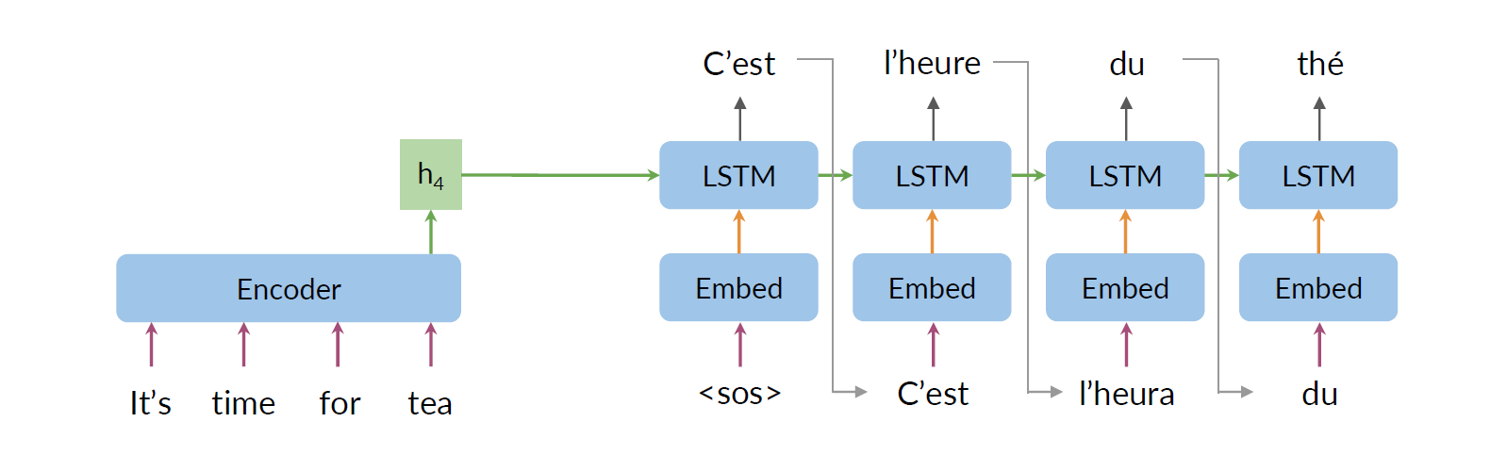

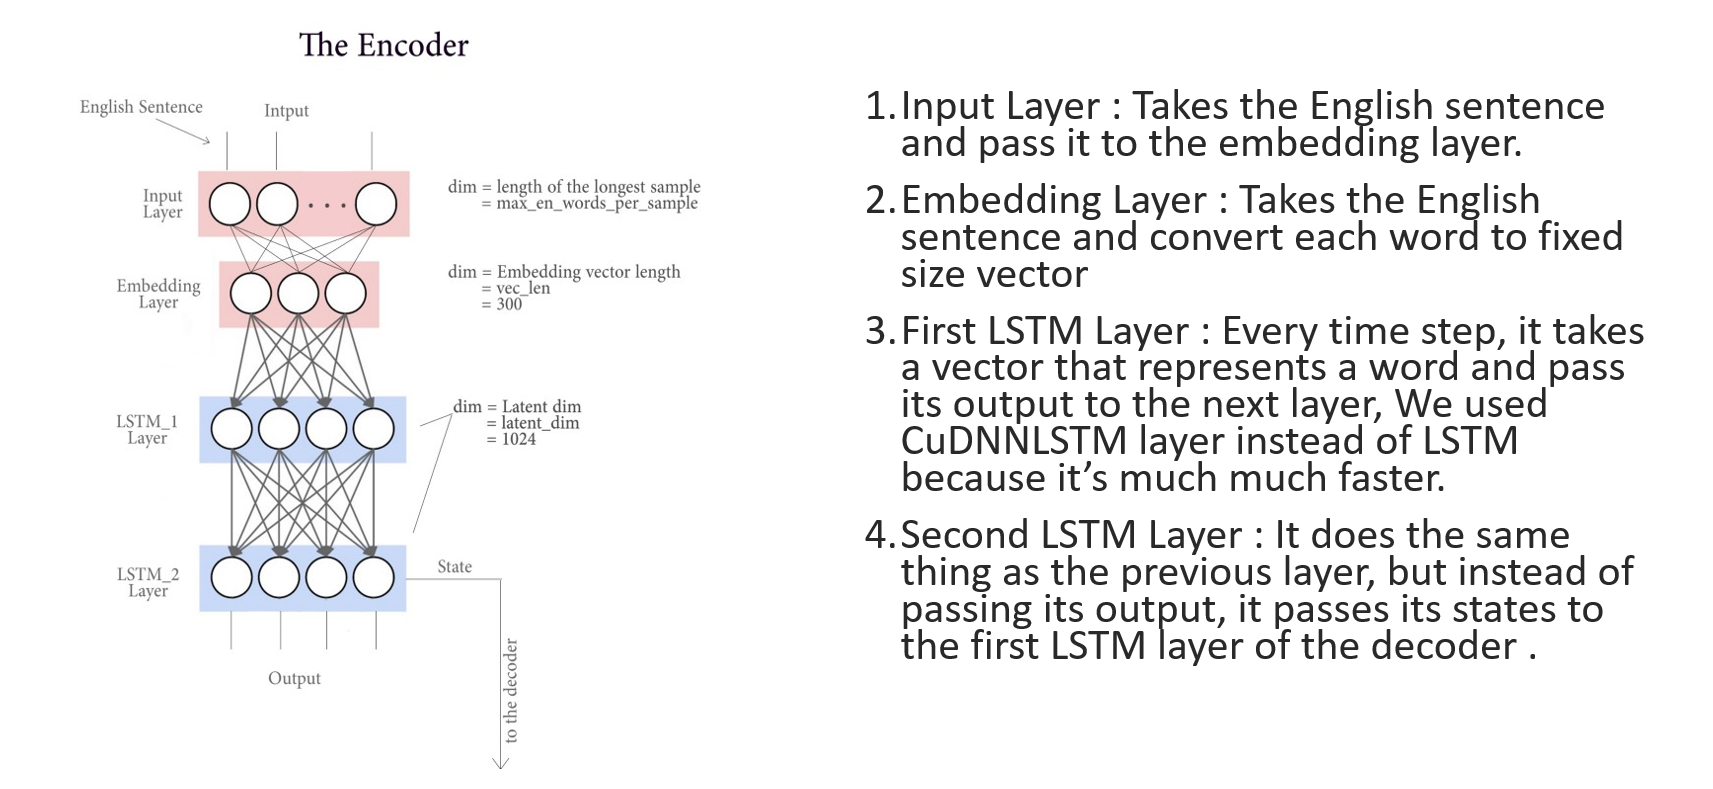

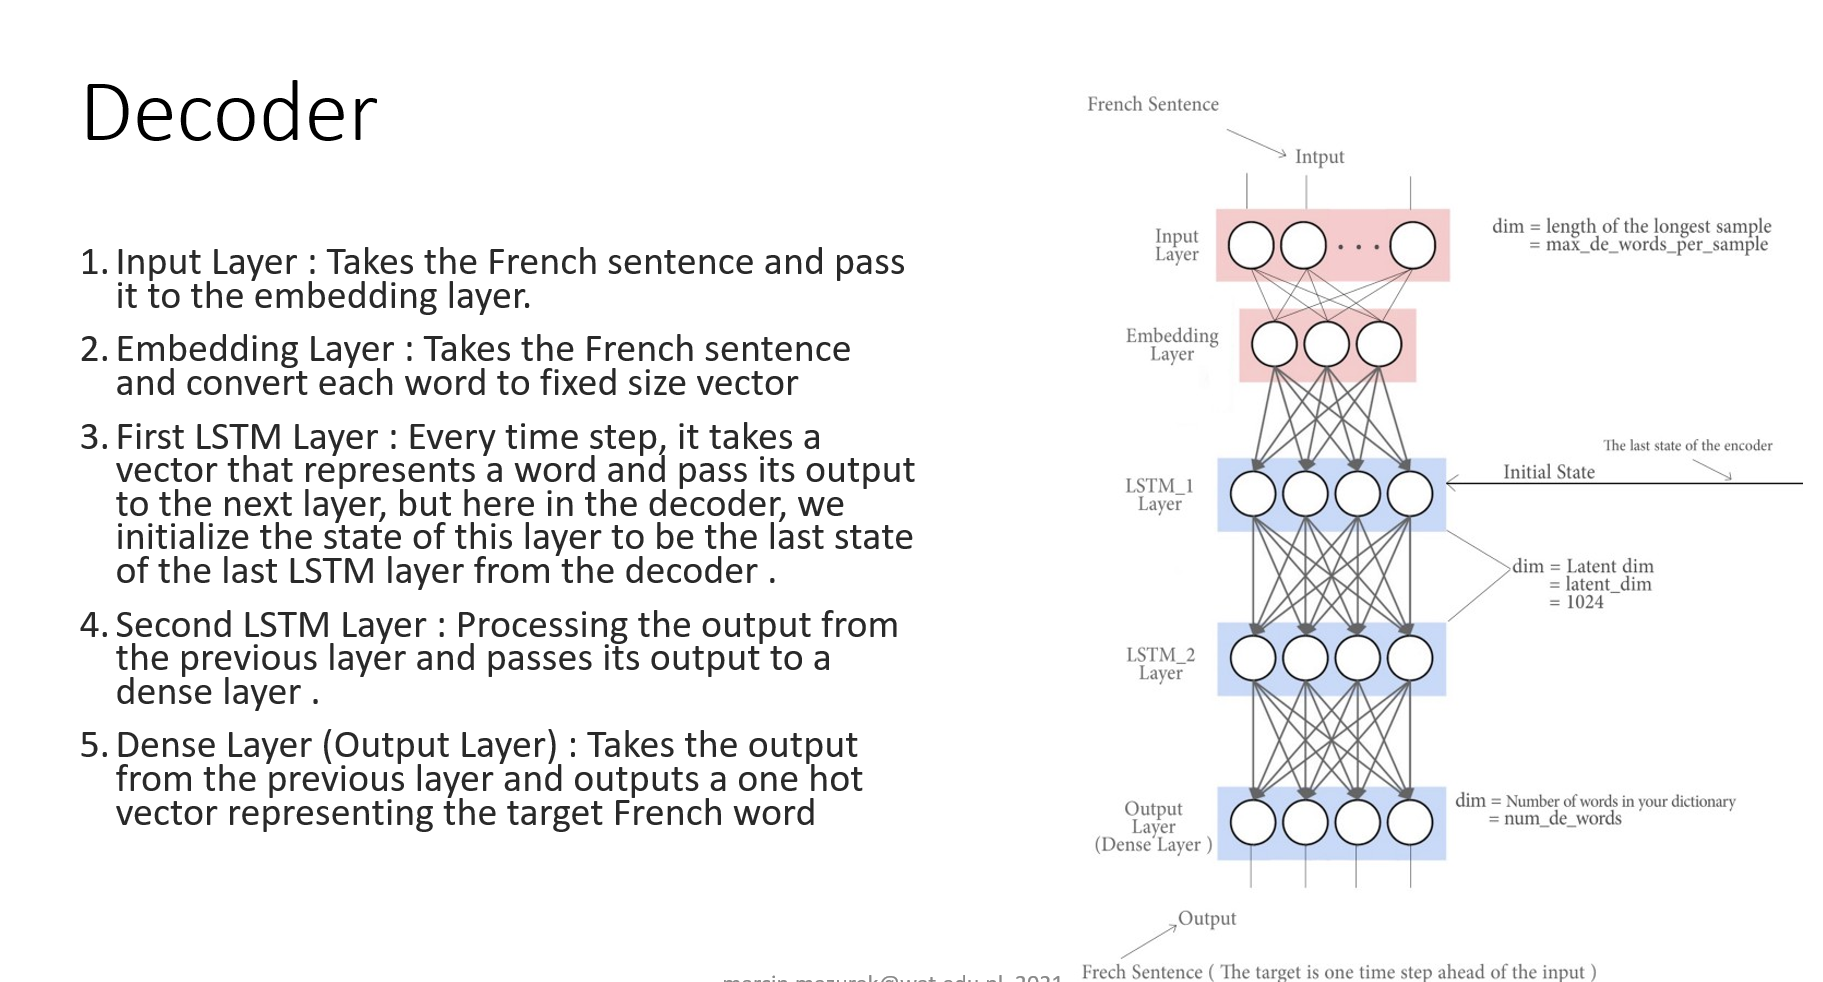

Przykładowa architektura sieci:
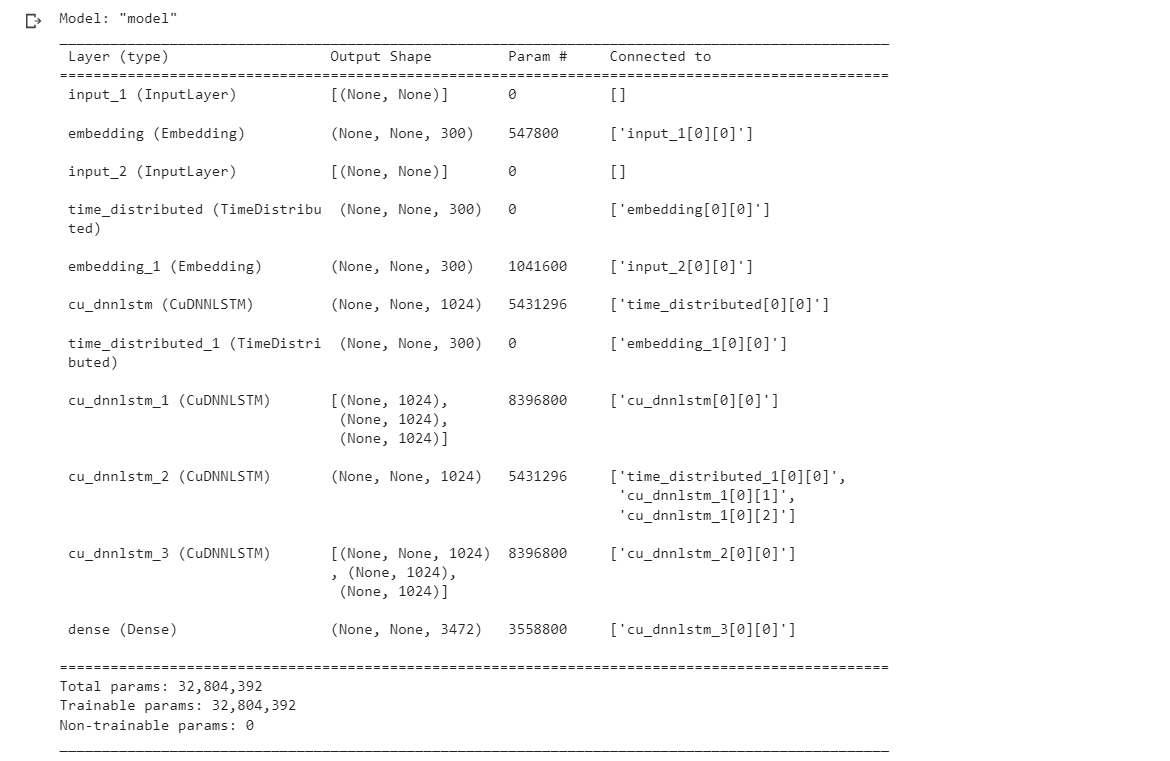

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM
from tabulate import tabulate

In [17]:
# 1. Pobranie danych
data = yf.download('AAPL', start='2020-01-01', end='2022-12-31')
data = data[['Open']]

# 2. Normalizacja danych
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

[*********************100%***********************]  1 of 1 completed


In [18]:
# 3. Utworzenie sekwencji
def create_sequences(data, sequence_length, shuffle_sequences=False):
    combined = []
    for i in range(len(data) - sequence_length):
        X_seq = data[i:i + sequence_length]  # Wcześniejsze wartości
        y_seq = data[i + sequence_length]   # Analizowany punkt
        combined.append((X_seq, y_seq))

    if shuffle_sequences:
        random.shuffle(combined)  # Tasowanie całości

    X, y = zip(*combined)

    return np.array(X), np.array(y)

sequence_length = 30  # Długość sekwencji
X, y = create_sequences(data_scaled, sequence_length)

# Podział na zbiór treningowy i walidacyjny
split = int(len(X) * 0.7)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

def get_data_sets(sequence_length, split_ratio=0.7):
  split = int(len(X) * split_ratio)
  X_train, X_val = X[:split], X[split:]
  y_train, y_val = y[:split], y[split:]
  return (X_train, X_val), (y_train, y_val)

(X_train, X_val), (y_train, y_val) = get_data_sets(sequence_length)

In [19]:
# 4. Budowa modelu rekurencyjnego - RNN
def build_rnn_model(sequence_length, units=20):

  rnn_model = Sequential([
      Input(shape=(sequence_length, 1)),  # Input -> (batch_size, sequence_length, features)
      SimpleRNN(20),  # SimpleRNN -> (batch_size, units)
      Dense(1)  # Dense -> (batch_size, output_dim), weights * input + bias
  ])

  rnn_model.summary()

  rnn_model.compile(optimizer='adam', loss='mse')

  rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

  return rnn_model

rnn_model = build_rnn_model(sequence_length)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 20)                  │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.2044 - val_loss: 0.0901
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0324 - val_loss: 0.0164
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107 - val_loss: 0.0077
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

In [20]:
# 5. Budowa modelu Long Short-Term Memory - LSTM

def build_lstm_model(sequence_length, units=20):

  lstm_model = Sequential([
      Input(shape=(sequence_length, 1)),  # Input -> (batch_size, sequence_length, features)
      LSTM(20, return_sequences=True),  # LSTM1 -> (batch_size, sequence_length, units)
      LSTM(20),  # LSTM2 -> (batch_size, units)
      Dense(1)  # Dense -> (batch_size, output_dim), weights * input + bias
    ])

  lstm_model.summary()

  lstm_model.compile(optimizer='adam', loss='mse')

  lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64)

  return lstm_model

lstm_model = build_lstm_model(sequence_length)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 20)              │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.2948 - val_loss: 0.2227
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0856 - val_loss: 0.0101
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0124 - val_loss: 0.0210
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0164 - val_loss: 0.0068
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0080 - val_loss: 0.0121
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0079 - val_loss: 0.0037
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0021 - val_lo

In [21]:
# 6. Prognoza na rok 2023
data_2023 = yf.download('AAPL', start='2023-01-01', end='2024-01-01')[['Open']]
data_2023_scaled = scaler.transform(data_2023)

X_2023, y_2023 = create_sequences(data_2023_scaled, sequence_length)
y_pred_rnn = rnn_model.predict(X_2023)
y_pred_lstm = lstm_model.predict(X_2023)

y_pred_rnn = scaler.inverse_transform(y_pred_rnn)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_actual = scaler.inverse_transform(y_2023)

# Naiwna predykcja
y_pred_naive = data_2023['Open'].shift(1).bfill().values.reshape(-1, 1)[sequence_length:]

[*********************100%***********************]  1 of 1 completed


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


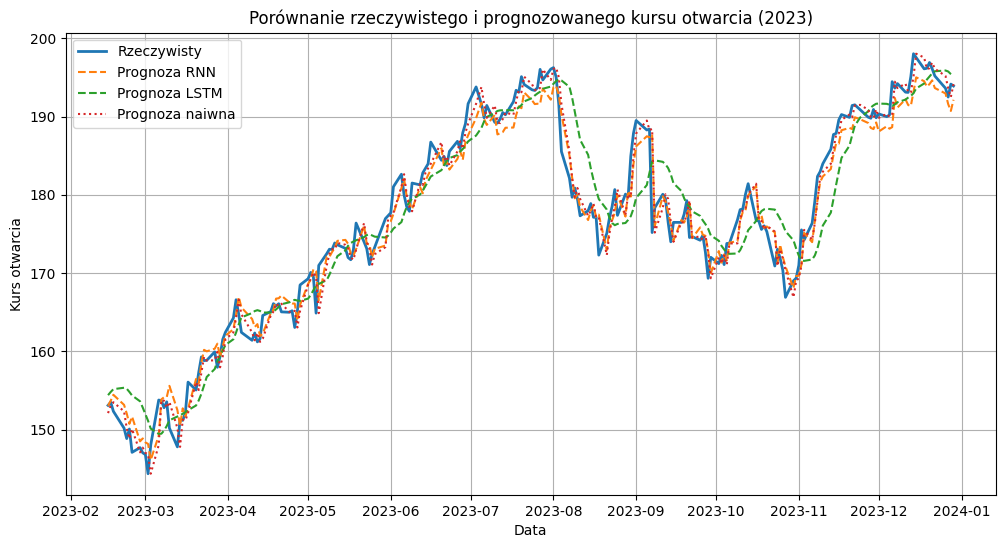

In [22]:
# 7. Wizualizacja wyników
plt.figure(figsize=(12, 6))
plt.plot(data_2023.index[sequence_length:], y_actual, label='Rzeczywisty', linewidth=2)
plt.plot(data_2023.index[sequence_length:], y_pred_rnn, label='Prognoza RNN', linestyle='--')
plt.plot(data_2023.index[sequence_length:], y_pred_lstm, label='Prognoza LSTM', linestyle='--')
plt.plot(data_2023.index[sequence_length:], y_pred_naive, label='Prognoza naiwna', linestyle=':')
plt.title('Porównanie rzeczywistego i prognozowanego kursu otwarcia (2023)')
plt.xlabel('Data')
plt.ylabel('Kurs otwarcia')
plt.legend()
plt.grid()
plt.show()

In [23]:
# 7. Obliczenie miar trafności
# RNN
mse_rnn = mean_squared_error(y_actual, y_pred_rnn)
mae_rnn = mean_absolute_error(y_actual, y_pred_rnn)
r2_rnn = r2_score(y_actual, y_pred_rnn)

# LSTM
mse_lstm = mean_squared_error(y_actual, y_pred_lstm)
mae_lstm = mean_absolute_error(y_actual, y_pred_lstm)
r2_lstm = r2_score(y_actual, y_pred_lstm)

# Naiwna predykcja
mse_naive = mean_squared_error(y_actual, y_pred_naive)
mae_naive = mean_absolute_error(y_actual, y_pred_naive)
r2_naive = r2_score(y_actual, y_pred_naive)

# Wyświetlenie wyników
print("Trafność predykcji - RNN:")
print(f"MSE: {mse_rnn:.4f}")
print(f"MAE: {mae_rnn:.4f}")
print(f"R²: {r2_rnn:.4f}")

print()

print("Trafność predykcji - LSTM:")
print(f"MSE: {mse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"R²: {r2_lstm:.4f}")

print()

print("Trafność predykcji - predykcja naiwna")
print(f"MSE: {mse_naive:.4f}")
print(f"MAE: {mae_naive:.4f}")
print(f"R²: {r2_naive:.4f}")

Trafność predykcji - RNN:
MSE: 5.8543
MAE: 1.9233
R²: 0.9672

Trafność predykcji - LSTM:
MSE: 16.7917
MAE: 3.2453
R²: 0.9059

Trafność predykcji - predykcja naiwna
MSE: 4.7907
MAE: 1.6155
R²: 0.9731


In [24]:
# Wnioski:

# Przy tej samej lcizbie epok RNN radził sobie znacznie lepiej od LSTM, dlatego LSTM otrzymał 2 razy więcej epok
# Ta różnica wynika z tego, że LSTM ma bardziej złożoną strukturę

# Wynik działania dla aktualnych parametrów przedstawiony jest na wykresie.
# Widać po nim, że predykcja dla obu modeli jest dość zbliżona w rzeczywistych wartości.

# Analizując liczbowo obliczone wartości trafności predykcji potwierdzają to, pokazując
# wartość błędu dla najmniejszych kwadratów (MSE) odpowiednio 14.2694 dla RNN oraz 28.2199 dla LSTM

# Podsumowując analizę widać, że przy dwukrotnie większej liczbie epok LSTM nadal poradził
# sobie gorzej, wynika to z rozmiaru problemu, dla którego prosta sieć rekurencyjna
# jest wystarczająca, a LSTM przez użycie bramek posiada znacznie więcej wartości
# do przeliczenia

In [29]:
# Uruchomienie predykcji dla różnych długości

def get_all_params_set(l):
    def get_pred_params():
        return {'mse': None, 'mae': None, 'r2': None}

    return {'l': l, 'rnn': get_pred_params(), 'lstm': get_pred_params(), 'naive': get_pred_params()}

sequence_lengths = [10, 20, 80, 100]

different_sequences_values = [get_all_params_set(l) for l in sequence_lengths]

for ind, sequence_case in enumerate(different_sequences_values):

    seq_len = sequence_case['l']

    (X_train, X_val), (y_train, y_val) = get_data_sets(seq_len)

    rnn_model = build_rnn_model(seq_len)
    lstm_model = build_lstm_model(sequence_length)

    data_2023 = yf.download('AAPL', start='2023-01-01', end='2024-01-01')[['Open']]
    data_2023_scaled = scaler.transform(data_2023)

    X_2023, y_2023 = create_sequences(data_2023_scaled, seq_len)
    y_pred_rnn = rnn_model.predict(X_2023)
    y_pred_lstm = lstm_model.predict(X_2023)

    y_pred_rnn = scaler.inverse_transform(y_pred_rnn)
    y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
    y_actual = scaler.inverse_transform(y_2023)

    # RNN
    mse_rnn = mean_squared_error(y_actual, y_pred_rnn)
    mae_rnn = mean_absolute_error(y_actual, y_pred_rnn)
    r2_rnn = r2_score(y_actual, y_pred_rnn)

    # LSTM
    mse_lstm = mean_squared_error(y_actual, y_pred_lstm)
    mae_lstm = mean_absolute_error(y_actual, y_pred_lstm)
    r2_lstm = r2_score(y_actual, y_pred_lstm)

    # Naiwna predykcja
    y_pred_naive = data_2023['Open'].shift(1).bfill().values.reshape(-1, 1)[seq_len:]
    mse_naive = mean_squared_error(y_actual, y_pred_naive)
    mae_naive = mean_absolute_error(y_actual, y_pred_naive)
    r2_naive = r2_score(y_actual, y_pred_naive)

    # Wyświetlenie wyników
    print(f" sequence length = {seq_len} ".center(100, "="))
    print("Trafność predykcji - RNN:")
    print(f"MSE: {mse_rnn:.4f}")
    print(f"MAE: {mae_rnn:.4f}")
    print(f"R²: {r2_rnn:.4f}")

    different_sequences_values[ind]['rnn']['mse'] = mse_rnn
    different_sequences_values[ind]['rnn']['mae'] = mae_rnn
    different_sequences_values[ind]['rnn']['r2'] = r2_rnn

    print()

    print("Trafność predykcji - LSTM:")
    print(f"MSE: {mse_lstm:.4f}")
    print(f"MAE: {mae_lstm:.4f}")
    print(f"R²: {r2_lstm:.4f}")

    different_sequences_values[ind]['lstm']['mse'] = mse_lstm
    different_sequences_values[ind]['lstm']['mae'] = mae_lstm
    different_sequences_values[ind]['lstm']['r2'] = r2_lstm

    print()

    print("Trafność predykcji - predykcja naiwna:")
    print(f"MSE: {mse_naive:.4f}")
    print(f"MAE: {mae_naive:.4f}")
    print(f"R²: {r2_naive:.4f}")

    different_sequences_values[ind]['naive']['mse'] = mse_naive
    different_sequences_values[ind]['naive']['mae'] = mae_naive
    different_sequences_values[ind]['naive']['r2'] = r2_naive

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)             │ (None, 20)                  │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0802 - val_loss: 0.0097
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 30, 20)              │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.3369 - val_loss: 0.2599
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1059 - val_loss: 0.0111
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0168 - val_loss: 0.0150
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0191 - val_loss: 0.0103
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0104 - val_loss: 0.0170
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0106 - val_loss: 0.0052
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0063 - val_loss: 0.0043
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0025 - val_lo

[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
======================================= sequence length = 10 =======================================
Trafność predykcji - RNN:
MSE: 68.7133
MAE: 7.7321
R²: 0.7162

Trafność predykcji - LSTM:
MSE: 19.4636
MAE: 3.3973
R²: 0.9196

Trafność predykcji - predykcja naiwna:
MSE: 4.9057
MAE: 1.6548
R²: 0.9797


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)            │ (None, 20)                  │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.6946 - val_loss: 0.2732
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0911 - val_loss: 0.0159
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0141 - val_loss: 0.0081
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step -

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 30, 20)              │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.3309 - val_loss: 0.3362
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1432 - val_loss: 0.0689
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0261 - val_loss: 0.0145
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0273 - val_loss: 0.0064
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0123 - val_loss: 0.0214
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0126 - val_loss: 0.0093
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0079 - val_loss: 0.0047
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0031 - val_lo

[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
======================================= sequence length = 20 =======================================
Trafność predykcji - RNN:
MSE: 9.1112
MAE: 2.4353
R²: 0.9543

Trafność predykcji - LSTM:
MSE: 44.5864
MAE: 5.4176
R²: 0.7765

Trafność predykcji - predykcja naiwna:
MSE: 4.9466
MAE: 1.6490
R²: 0.9752


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)            │ (None, 20)                  │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.7509 - val_loss: 0.3256
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1339 - val_loss: 0.0443
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0572 - val_loss: 0.0405
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0223 - val_loss: 0.0208
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0128 - val_loss: 0.0094
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 30, 20)              │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.4091 - val_loss: 0.3484
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1459 - val_loss: 0.0412
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0170 - val_loss: 0.0246
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0274 - val_loss: 0.0047
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0092 - val_loss: 0.0159
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0029 - val_lo

[*********************100%***********************]  1 of 1 completed


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
======================================= sequence length = 80 =======================================
Trafność predykcji - RNN:
MSE: 29.0224
MAE: 4.5227
R²: 0.6073

Trafność predykcji - LSTM:
MSE: 22.3160
MAE: 3.8437
R²: 0.6981

Trafność predykcji - predykcja naiwna:
MSE: 5.1216
MAE: 1.6484
R²: 0.9307


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_12 (SimpleRNN)            │ (None, 20)                  │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.4578 - val_loss: 0.0240
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0720 - val_loss: 0.0785
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0334 - val_loss: 0.0279
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0253 - val_loss: 0.0223
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0183 - val_loss: 0.0208
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0161 - val_loss: 0.0142
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0169 - val_loss: 0.0155
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0154 - val_loss: 0.0179
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0126 - val_loss: 0.0129
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0115 - val_loss: 0.0119
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 30, 20)              │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.4218 - val_loss: 0.4122
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1882 - val_loss: 0.1289
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0497 - val_loss: 0.0059
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0203 - val_loss: 0.0096
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0096 - val_loss: 0.0121
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0085 - val_loss: 0.0043
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0030 - val_lo

[*********************100%***********************]  1 of 1 completed


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
====================================== sequence length = 100 =======================================
Trafność predykcji - RNN:
MSE: 8.4774
MAE: 2.1100
R²: 0.8719

Trafność predykcji - LSTM:
MSE: 22.7248
MAE: 3.9041
R²: 0.6567

Trafność predykcji - predykcja naiwna:
MSE: 5.1283
MAE: 1.6511
R²: 0.9225


In [30]:
data_for_table = []

for entry in different_sequences_values:
    data_for_table.append({
        "Seq len": entry['l'],
        "RNN MSE": entry['rnn']['mse'],
        "RNN MAE": entry['rnn']['mae'],
        "RNN R²": entry['rnn']['r2'],
        "LSTM MSE": entry['lstm']['mse'],
        "LSTM MAE": entry['lstm']['mae'],
        "LSTM R²": entry['lstm']['r2'],
        "naive MSE": entry['naive']['mse'],
        "naive MAE": entry['naive']['mae'],
        "naive R²": entry['naive']['r2'],
    })

df_results = pd.DataFrame(data_for_table)
print(tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════╤═══════════╤═══════════╤══════════╤════════════╤════════════╤═══════════╤═════════════╤═════════════╤════════════╕
│   Seq len │   RNN MSE │   RNN MAE │   RNN R² │   LSTM MSE │   LSTM MAE │   LSTM R² │   naive MSE │   naive MAE │   naive R² │
╞═══════════╪═══════════╪═══════════╪══════════╪════════════╪════════════╪═══════════╪═════════════╪═════════════╪════════════╡
│        10 │  68.7133  │   7.73206 │ 0.716203 │    19.4636 │    3.39734 │  0.919612 │     4.90574 │     1.65479 │   0.979739 │
├───────────┼───────────┼───────────┼──────────┼────────────┼────────────┼───────────┼─────────────┼─────────────┼────────────┤
│        20 │   9.11115 │   2.43526 │ 0.954328 │    44.5864 │    5.41762 │  0.776501 │     4.94663 │     1.64896 │   0.975204 │
├───────────┼───────────┼───────────┼──────────┼────────────┼────────────┼───────────┼─────────────┼─────────────┼────────────┤
│        80 │  29.0224  │   4.52266 │ 0.607318 │    22.316  │    3.84369 │  0.698058 │     5.12162 │    

In [31]:
# Wnioski:

# Analizując wyniki dla różnych długości sekwencji widać, że wraz z ich wzrostem
# predykcja ma wartości coraz bliższe rzeczywistym wartościom. Porównując wyniki
# między modelem RNN a LSTM widać, że dla małych dugości przewagę ma LSTM, a ze
# wzrostem długości sekwencji przewagę zdobywa RNN

# Naiwna predykcja pokazuje mniejszy błąd dla każdej długości sekwencji. Wskazuje to na to, że